## Learning From Unstructured Data
# Assignment 1

**Author:** Julia Będziechowska

**Student Number:** 56547

# TensorFlow

What is `TensorFlow`? 
The official page says:   
>TensorFlow is an open-source machine learning library for research and production. TensorFlow offers APIs for beginners and experts to develop for desktop, mobile, web, and cloud

pinpointing at least two reasons (or, alternatively, nowadays buzz-words) to learn it:
 - machine learning
 - open-source



In this tutorial, I would like to share my basic knowledge concerning this popular framework. It is made as an assignment project for *Learning from Unstructured Data* course. Therefore, it consists of datasets and exercises used during these classes.




### Everything's set up? 

Before digging into Tensorflow, let's make sure we have it installed, by displaying current Tensorflow's version. From now on, we will have the library imported under the alias `tf`.

In [1]:
import tensorflow as tf
print("Tensorflow", tf.__version__)

Tensorflow 1.13.1


Great!
Let's start the tutorial with understanding what is the idea of `TensorFlow`.

Tensorflow is a **dataflow programming framework**.

This means that we define and run a so called **computation graph**:
 - In each node, we can store operations, such as addition, multiplication. 
 - On the edges, we store inputs / outputs of these functions. These can be represented as N-ranked matrices, which are called **Tensors**.
 
The **Tensors** carry the data **flowing** in the graph.
> Control question: Why is Tensorflow called Tensorflow? :)

What is the reason for organizing data flow in such way? 

 - For a graph given, the dependencies between nodes are described explicitly. This makes it easier to exploit parallelism and distribution across multiple devices: CPUs, GPUS and others. Imagine a visualization of a graph, so that we can see at a quick glance which nodes can be executed in parallel, as the data flows in different channels (on different edges). 
 
Great promise of optimized computations! But we also have to note, that no matter how great is the graph we design, it will remain **static at run time**. Once the graph will be running, it is impossible to change it. 



### The APIs

TensorFlow exposes so called `Graph API`. We can use not only Python, but also GoLang, Java and C++ and provided library, helping to write out a graph in a special format, known as protobuf. 
> Protocol buffers are Google's language-neutral, platform-neutral, extensible **mechanism for serializing structured data** – think XML, but smaller, faster, and simpler. 

There is also `Session API`, providing an interface to the *Tensorflow C++ Runtime*. This is where all the *heavy lifting* and *logic behind computational nodes* happens, as well as ultimate distribution of operations to be executed on the hardware.  

### Creating first graph

Let's create first simple computation graph, that will add two numbers together. Because this tutorial is built of jupyter notebook cells, we begin with a cell that will make sure we have everything cleaned up:

In [2]:
# Clear the default graph stack 
# and reset the global default graph.

# Use to play around and avoid 'dead nodes'...

tf.reset_default_graph()

Three main data types of TensorFlow are:
1. Constants
2. Variables
3. Placeholders

To begin with, we will store two numbers in variables that are constants. We can put a `value` inside, which is of `dtype`, will not change (because is constant), and give it a `name`. For addition, we use `tf.add` function, which will return variable to store the result.

In [3]:
tf.reset_default_graph()

a = tf.constant(1.0, dtype=tf.float32, name='a')
b = tf.constant(2.0, dtype=tf.float32, name='b')
result = tf.add(a, b, name='result')

What can we do next?

In [4]:
print(result)

Tensor("result:0", shape=(), dtype=float32)


Using Python's `print` operation, we clearly see that we did not print the actual result. Instead, we printed information concerning tensor what will store that result. This is because we defined a graph, put some constant values, but did not let the data flow yet.

Therefore, we have to make use of already mentioned `Session API` to run the graph (or we can also run part of graph, if we would like to).

In [5]:
with tf.Session() as sess:
    print("Result =", sess.run(result))
    
### Alternatively:
# sess = tf.Session()
# print("Result =", sess.run(result))
# sess.close()

Result = 3.0


A default session is defined by calling `tf.Session()`. Then, we fire up the graph and calculate the result by running `sess.run(result)`. 

In the cell above, there is an alternative way of more manual management of session, but it is better to make use of Python's `with` statement for safety.

____________________________

After this introduction, we should move on to some machine learning! Recall all computations' and matrices' of data friend, `numpy`:

In [6]:
import numpy as np

and we can start with implementing Logistic Regression in Tensorflow.

### Logistic Regression


Let's use gene activity data, which is already stored in *data* directory. First, we need to read data from file, take Xs and Ys, as well as perform z-score normalization.

In [7]:
mat = np.loadtxt('data/gene_data.txt', delimiter='\t', dtype=np.float32)
Ys = mat[:, [-1]]
Xs = mat[:, :-1]
means = np.mean(Xs, 0)
stdevs = np.std(Xs, 0)
Xs = (Xs-means)/stdevs

print("{}:\n {} data records, described by {} features".format('data/gene_data.txt', str(Xs.shape[0]), str(Xs.shape[1])))

data/gene_data.txt:
 36 data records, described by 2 features


We prepare **constant** tensors to store data which we just read from file. 

Then, we need to create **variables** that will store parameters of logistic regression. These are `weights` and `bias`, that we expect to be altered by the algorithm, heading more optimal solution. In TensorFlow, variables represent a tensors whose values can be changed by running operations on them.
> A TensorFlow variable is the best way to represent shared, persistent state manipulated by your program.

 - for `weights`, we make use of `tf.random_normal` that outputs random values from a normal distribution, for given shape: (2, 1), which stands for 2 features we have, per one record of data at a time *although we will in general perform matrix operations*
 - we set initial value of `bias` to 0.0
 - we define `net` tensor, using `tf.matmul` and `tf.add` for calculating weighted linear combination of the input, with a bias
 - and `output` tensor, which we obtain by applying `sigmoid` function for the tensor above
 
Looks like we have all components of logistic regression - we can input some data and receive some output prediction - but we still need another ones to make the learning possible. Therefore, we further define:

 - logistic `cost` function: notice that we use tensors joined together with arithmetical operations, that also results in a suitable tensor; applying `tf.reduce_mean` is equivalent to `np.mean` - simply averaging over all elements
 - an `optimizer`, which is an instance of `GradientDescentOptimizer` class, that implements algorithm specified in its name; we set its `learning_rate` to 0.1
 - and `training_op`, result of calling `minimize` function which is a method of the class used above
 
At a first glance, it seems as we didn't need to know much about Gradient Descent algorithm, as it is already implemented and easy to use. This is one of the advantages TensorFlow has, that does not concern performance and low-level characteristics, but rather convenience and flexibility at the same time.

>What happens in `.minimize(loss=cost)`?
<br>This function first computes gradients of all variables provided. TensorFlow automatically assumes that user-defined variables will be *trained*. Indeed, we defined complete graph, as well as `cost` that depends on `output`, and so on... 
For each variable, the gradient can be another Tensor, or can represent None when no gradient exists. 



In [9]:
tf.reset_default_graph() # :) 

X = tf.constant(Xs, name="X")
y = tf.constant(Ys, name="y")

weights = tf.Variable(tf.random_normal(shape=(2, 1)), name="weights")
bias = tf.Variable(0.0, name="bias")
net = tf.add(tf.matmul(X, weights), bias, name="net")
output = tf.nn.sigmoid(net, name="output")

cost = -tf.reduce_mean(y * tf.log(output) + (1-y) * (tf.log(1-output)))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.25)
training_op = optimizer.minimize(loss=cost)

Now we have all set and will run the graph 20 times. This means that we will calculate current loss 20 times, calculating the gradient each time and adjusting the weights based on learning rate.

Because as the documentation states, variable initializers must be run explicitly before other operations (and we surely have declared some), we will use convenient one-line method that will do the trick. This is included in the first line below.

Notice how we pass tensors as parameters to the `sess.run` method, so that they are executed and returned. We skip the first variable returned by `.minimize` by a `_` variable, for it will not output any number that is in our interest; we rather want it to perform calculations and result in weights changing. 

Running the cell below will train our model 20 times, and print current logistic loss for each epoch.

In [11]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(20):
        _, current_loss = sess.run([training_op, cost])
        print("{} : {}".format(str(epoch+1), str(current_loss)))
    sess.close()

1 : 0.29437947
2 : 0.2851331
3 : 0.27671987
4 : 0.26902333
5 : 0.2619482
6 : 0.25541553
7 : 0.24935967
8 : 0.24372523
9 : 0.23846538
10 : 0.23354012
11 : 0.22891514
12 : 0.2245608
13 : 0.22045135
14 : 0.21656434
15 : 0.21288003
16 : 0.20938107
17 : 0.20605221
18 : 0.20287968
19 : 0.19985141
20 : 0.19695652


Now we should be happy to see that after each epoch, the loss value tends to decrease, so our graph is working. 

But we want something more from TensorFlow, and this 'something' is probably *neural networks*. How would a very simple neural network look like?

We already have an example with logistic regression, and we can think of it as a one layer neural network. Therefore, the example of single neuron that represents OR should be from now understandable. It only differs from the Logistic Regression example by the objective function, which is not a logistic loss, but a mean squared error. It is not a big change at all; we take same tensors to determine the value of loss, but apply different operations.



### One neuron that learns OR function

In [12]:
tf.reset_default_graph()

# Pairs of inputs (possible combinations)
Xs = np.array([(0,0), (0,1), (1,0), (1,1)])
# Results on applying OR function on the pairs above
Ys = np.array([0, 1, 1, 1])

X = tf.constant(Xs.astype(np.float32), name="X")
y = tf.constant(Ys.astype(np.float32).reshape((-1,1)), name="y")

weights = tf.Variable(tf.random_normal((2,1)), name="weights")
bias = tf.Variable(0.0, name="bias")
net = tf.add(tf.matmul(X, weights), bias, name="net")
output = tf.nn.sigmoid(net, name="output")

mse = tf.reduce_mean(tf.square(y-output),name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
training_op = optimizer.minimize(loss=mse)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(1001):
        _, current_mse = sess.run([training_op, mse])
        if epoch % 100 == 0:
            print("{} : mse={}".format(str(epoch), str(current_mse)))

0 : mse=0.11109069
100 : mse=0.08929624
200 : mse=0.074938536
300 : mse=0.06414271
400 : mse=0.055788253
500 : mse=0.049178332
600 : mse=0.043838214
700 : mse=0.039443944
800 : mse=0.035771236
900 : mse=0.03266098
1000 : mse=0.029997472


### XOR Troubles

The disadvantage of having only one neuron is that we can question it by a popular *counter-argument* - can one neuron learn XOR function? 
> No, because one neuron is just a linear classifier, and we can not separate XOR with only one line to split the space

Therefore, we will now implement a small neural network with one hidden layer, that can solve the XOR problem, and see how we can connect more units together.



More neurons and layers naturally imply that we will need more tensors. It is clearly visible in the code cell below - we define weights, bias, net and output tensors for each of the neurons. Two integer numbers are added to variables' names', first of them indicates number of layer (hidden has number 1, the next one is output layer and has number 2), and the next number is for numbering a neuron within its layer.

> Notice how we multiply tensor `X` with both `weights11` and `weights12` for each neuron, subsequently adding bias.
<br>To join outputs of two neurons in hidden layer together, we make use of `tf.concat` function, that concatenates two hidden layer outputs along columns (it is specified by axis=1, as we index axis starting from 0 - rows)

It wasn't that hard, many things look similar to what we already know! Run the cell below and see how it works, will those neurons learn?

In [13]:
tf.reset_default_graph()

# Pairs of inputs (possible combinations)
X = tf.constant(np.array([(0,0),(0,1),(1,0),(1,1)]).astype(np.float32), name="X")
# Results on applying XOR function on the pairs above
y = tf.constant(np.array([0,1,1,0]).astype(np.float32).reshape((-1,1)), name="y")

# HIDDEN LAYER:
#     1st neuron:
weights11 = tf.Variable(tf.random_normal((2, 1)), name="weights11")
bias11 = tf.Variable(0.0, name="bias11")
net11 = tf.add(tf.matmul(X, weights11), bias11, name="net11")
output11 = tf.nn.sigmoid(net11, name="output11")

#     2nd neuron:
weights12 = tf.Variable(tf.random_normal((2, 1)), name="weights12")
bias12 = tf.Variable(0.0, name="bias12")
net12 = tf.add(tf.matmul(X, weights12), bias12, name="net12")
output12 = tf.nn.sigmoid(net12, name="output12")

# OUTPUT LAYER:
#     just one neuron:
weights21 = tf.Variable(tf.random_normal((2, 1)), name="weights21")
bias21 = tf.Variable(0.0, name="bias21")

input21 = tf.concat([output11, output12], axis=1)

net21 = tf.add(tf.matmul(input21, weights21), bias21, name="net12")
output = tf.nn.sigmoid(net21, name="output")

mse = tf.reduce_mean(tf.square(y-output),name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
training_op = optimizer.minimize(loss=mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(20001):
        _, cost = sess.run([training_op, mse])
        if epoch % 2000 == 0:
            print("{} : mse={}".format(str(epoch), str(cost)))

0 : mse=0.30630922
2000 : mse=0.2490517
4000 : mse=0.23445475
6000 : mse=0.18716346
8000 : mse=0.10616985
10000 : mse=0.026843872
12000 : mse=0.011687108
14000 : mse=0.007034794
16000 : mse=0.004923149
18000 : mse=0.0037467622
20000 : mse=0.003006043


Well, we see that the network is learning, but the cell above is made up of 42 lines. For only four different pairs of binary values. We declared tensors that store each neuron's parameters separately. And used all examples existing at a time, each epoch...

This won't scale too good if the problem gets complicated. Thus, time to move to such problem! 

#### MNIST dataset

MNIST dataset is a very famous set of images of handwritten digits. It provides 60 000 examples in a training set, and 10 000 examples in a test set, all of which have been size-normalized and centered in a fixed-size image. Because of that, we can apply it easly in this tutorial, without spending time on preprocessing and formatting the data.

There is a function already provided that will prepare all the data we need. If needed, the dataset will be downloaded from the Internet, and then it will be cached locally.

In [14]:
from tensorflow import keras

mnist  = keras.datasets.mnist
(all_train_images, all_train_labels), (test_images, test_labels) = mnist.load_data()

print(all_train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


You can use the cell below to see a randomly picked image of digit with its label, or just skip this cell.

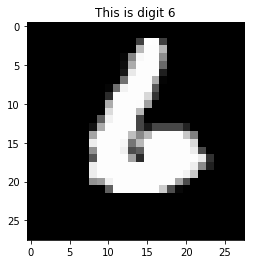

In [17]:
import matplotlib.pyplot as plt

random_idx = np.random.randint(0, len(all_train_images))
random_img = all_train_images[random_idx]
img_label = all_train_labels[random_idx]

plt.imshow(random_img, cmap='gray')
plt.title("This is digit {}".format(str(img_label)))
plt.show()

We can see that the dataset we loaded has matching sizes of training and test set, and that each image's size is 28x28 pixels in grayscale. 

Let's keep `test_images` data for the very end, final evaluation of the model we are about to create. Thus, we need to split entire training set to training and validation set. Say we need only 10.000 for validation and keep the rest for training.

Another thing that we need to do with our data is altering the dimensions. We are going to create a fully-connected layer, so that we can't really input 2D image into it. To achieve that, we will use:
 - `.reshape(-1, 28*28)`, in which we specified expected shape as `-1, 28*28`. What does it mean? `28*28` indicates that we want to create a 1D vector out of 2D image matrix. We further use `-1` that will tell the function to infer the remaining dimensions, in case we already forgot how many image samples we have ;)

In [18]:
valid_images = all_train_images[50000:].reshape(-1, 28*28)
valid_labels = all_train_labels[50000:]

train_images = all_train_images[:50000].reshape(-1, 28*28)
train_labels = all_train_labels[:50000]

test_images = test_images.reshape(-1, 28*28)

num_features = train_images.shape[1]
num_labels = len(np.unique(train_labels))

print(train_images.shape, valid_images.shape, test_images.shape)

(50000, 784) (10000, 784) (10000, 784)


The new size of `train_images` shows that we managed to *flatten* the images into 1D vectors, with 784 elements each. For readability, we also defined `num_features` variable, that should actually store number 784, for this is the amount of features that describe every single image. We also easly determine `num_labels` by counting all unique labels that can be found in `train_images` set of data.

Now, based on the previous conclusions about too much lines of code, let's write a function that will be able to create one layer of neurons. We would like to tell such function:

 - what is the input tensor that will provide thata to the layer we are creating,
 - how many neurons we would like to have in a layer,
 - which activation function we want to apply on the neurons, since we know many other than *sigmoid*,
 - and preferably give this layer a *name*, as we already saw that we can name the tensors
 
We mentioned above that it would be convenient to change each layer's activation function via the parameter. Well, in TensorFlow, there are many activation functions ready to use. You can check out all the possibities __[here](https://www.tensorflow.org/api_docs/python/tf/keras/activations)__.

Let us see the implementation of `layer()` function below:


### Function that returns `layer` based on passed parameters

In [19]:
def layer(inputs, neurons, name, activation_f=None):
    with tf.name_scope(name):
        weights = tf.Variable(tf.random_normal( (int(inputs.shape[1]), neurons) ), name="weights")
        bias = tf.Variable(tf.zeros(neurons), name="bias")
        net = tf.add(tf.matmul(inputs, weights), bias, name="net")
        if activation_f:
            try:
                return activation_f(net)
            except:
                print("Failed to apply activation_f")
                return net
        else:
            return net

First, we use `with` statement, followed by `tf.name_scope` function. This enables to create some context with a fixed name for the part of greater neural network graph we want to define, only for operation concerning current layer. We give this scope of one layer a name that user passed as an argument.

We prepare similar tensors for `weights`, `bias` and `net` as before, but you might note the difference here:
> `weights = tf.Variable(tf.random_normal( (int(inputs.shape[1]), neurons) ), name="weights")`
<br>Just because the number of weights, and the shape of a matrix which will represent them, depends now on the inputs and number of neurons we want to have in the layer. We also don't want to store weights separately for each neuron, so we keep them together in one matrix, what is a very common improvement, further friendly towards parallelism and GPUs. 

Later on, we just replaced `sigmoid` with an if statement that checks whether there was any activation function given, by which we mean the name of a function itself, so that you can choose whatever you want from those that are available. **This is for this tutorial purposes and normally it would be safer to just allow a string as an input, and then decode that string, with a success or failure.** :)

The function returns a result of applying activation function, or just weighted sum if this failed. Notice that such tensor returned could now serve as input to another layer, and we are now free to choose whether we want activation or not (for example, no activation for the very output layer).

### Placeholders Data Type

Before we move on, we now introduce the third datatype, **placeholder**. We already mentioned that but never used it. All the examples until now used:
 - some constants to store training data,
 - and some variables for parameters that we want to learn, for example weights initialized with normal distribution

But assuming you know how the training of a not too simple neural network look like, we need a way to input different subsets of our data into the network, like a batch of train images, or validation samples. Moreover, the size of batch  we will input is unlikely to be the same size as validation set, or test set that we will later use. This is where we should use placeholders!


In [20]:
tf.reset_default_graph()

# A placeholder for current set of samples, each represented by its features:
features = tf.placeholder(tf.float32, shape=(None, num_features))

# A placeholder for labels that will describe the current set of samples from above
labels = tf.placeholder(tf.int64, shape=(None))

# One-hot tensor for the labels that we have
one_hot_labels = tf.one_hot(labels, depth = num_labels,
                            on_value = 1.0, off_value = 0.0, axis = -1)

Above, we define `features` and `labels` placeholders. They have a fixed data type, and more-or-less **fixed shape**. Why more-or-less? Because we know that each image from MNIST that we have is described by 784 pixels, which number we store in `num_features`, but we also know that the number of that images may change within training and validation steps.
> We can use **None** for *any size*

In the above cell, we also showed how to create a tensor that will enable one-hot encoding of labels that we have. Thus, we expect as many neurons at the output layer as many we have different labels. Notice that the parameter of `tf.one_hot` here is `labels`, which is a placeholder.

Once we have placeholders, we can make use of them and create a network. Feel free to alter the activation function or number of neurons per each. You can also add new layers. But:
- we have to use `features` placeholder for the first layer for the images to flow,
- and we have to use `num_labels` for the output layer, so that we have enough nerons for our classification problem

In [21]:
# INPUT LAYER, we will input our images here, 
# thus - use a placeholder we created for them
in_layer = layer(features, 50, 'in_layer', activation_f=tf.nn.sigmoid)

# ONE HIDDEN LAYER, which input is the previous layer
h_layer1 = layer(in_layer, 25, 'h_layer1', activation_f=tf.nn.sigmoid)

# ... some more layers here if you want!

# OUTPUT LAYER, thus activation_f=None
out_layer = layer(h_layer1, num_labels, 'out_layer', activation_f=None)
# tip: num_labels here is 10, for we have 10 different digits

Now let's define the objective function and how we want the network to learn, just as we did before. We again need to define loss and choose an algorithm based on which we want to update weights. 

The problem is slightly different now as we want to predict label for each image that we input. In this case, we can use `softmax_cross_entropy` for the loss, that will determine its value based on one hot labels we provide, in comparison to so-called logits. In our case, we can find logits as last output layer of a network, that already has a correct size for that.

For determining probabilities of each class (label of a digit), we will use `softmax` function applied to the output layer. We can predict label for each image by taking the one with maximum probability (`tf.argmax`, along axis=1 which stands for columns in a matrix). See the cell below:

In [23]:
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
    onehot_labels=one_hot_labels,
    logits=out_layer))

learning_rate = 0.25
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

class_probabilities = tf.nn.softmax(out_layer)
prediction = tf.argmax(class_probabilities, axis=1)

We can define other metrix, for example `accuracy`, again combining operations that are implemented in TensorFlow. 

Below, `tf.equal` returns True or False values element-wise, comparing `labels` with `prediction`. We can cast those truth values using `tf.cast` to numerical representation in `tf.float32`, which will enable us to calculate simple average (`tf.reduce_mean`).

In [24]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, prediction), tf.float32))

Almost set! Now we can proceed with specifying how exactly we want the network to **learn**.

0. Specify `batch_size`, the amount of images we will input into our network at a time, and `num_epochs`, the number of epochs<br><br>
1. For each epoch:<br><Br>
    1. We take random images from training set of size same as `batch_size` (`batch_images`)
    2. We take coressponding labels (`batch_labels`)
    3. We *show* this batch to the network, and let the network learn something from it, updating weights as we specified with an optimizer<br>...<br>
    4. We repeat the steps above until we have used all unique images from the training set, then we are done with a single epoch
    5. Once finished, we can input validation images to the network, for example in order to read current `accuracy` and `loss`, and check network's ability to generalize.<br><br>
2. After training for `num_epochs`, the training is finished. Finally, we input our test data to the model we prepared and read accuracy we get on the data the network hasn't seen before. We may be also interested in reading some `predictions` or `out_layer` output for better experience.
    
The implementation of this idea can be found in the below cell. We can see some Python-numpy-like indexing that allows simple selection of random subsets of images for each batch. This is obtainable because we store images indices in `shuffled` array, and shuffle it at each epoch. 

One can note a special way of feeding the placeholders, that we promised to be flexible and convenient in use. We can see in line 17, that defines `batch_dict`, that we can define a dictionary of features and labels, what will further input what we specified into right placeholders. Note how we define different dicts in lines 22 and 27, to verify how the model is performing on both validation and traning sets. Using the latter ones, we just run our session with `[accuracy, loss]`, that means no traning is done, we only calculate the indicated measures that are in our interest.


### Training, valdation and test of Neural Network

In [25]:
shuffled = np.array(range(train_images.shape[0]))

batch_size = 100
num_epochs = 101 # Keep this number low if you are impatient :)

# Define simple lists to save network's progress
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

with tf.Session() as session:
    tf.global_variables_initializer().run(session=session)
    
    for epoch in range(num_epochs):
        offset = 0
        np.random.shuffle(shuffled)
        while offset < train_images.shape[0]:
            batch_images = train_images[shuffled[offset : offset+batch_size]]
            batch_labels = train_labels[shuffled[offset : offset+batch_size]]
            batch_dict = {features : batch_images, labels : batch_labels}
            session.run([optimizer], feed_dict=batch_dict)
            offset += batch_size

        # Check out the network with Validation set
        validation_dict = {features : valid_images, labels : valid_labels}
        val_acc, val_loss = session.run([accuracy, loss], feed_dict=validation_dict)
        # gather data for viz
        val_acc_history.append(val_acc); val_loss_history.append(val_loss)
        
        # Check out the netowork with Training set
        training_dict = {features : train_images, labels : train_labels}
        train_acc, train_loss = session.run([accuracy, loss], feed_dict=training_dict)
        # gather data for viz
        train_acc_history.append(train_acc); train_loss_history.append(train_loss)
        
        if epoch % 10 == 0:
            print("Epoch {}, validation acc: {}, training acc: {}".format(str(epoch), str(val_acc), str(train_acc)))
            
    test_dict = {features : test_images, labels : test_labels} 
    test_acc, test_predictions, test_logits = session.run([accuracy, prediction, out_layer], feed_dict=test_dict)
    print("\nTEST SET accuracy: {}".format(str(test_acc)))

Epoch 0, validation acc: 0.5823, training acc: 0.56766
Epoch 10, validation acc: 0.7919, training acc: 0.77342
Epoch 20, validation acc: 0.8394, training acc: 0.83668
Epoch 30, validation acc: 0.8691, training acc: 0.85508
Epoch 40, validation acc: 0.8682, training acc: 0.85734
Epoch 50, validation acc: 0.8722, training acc: 0.86102
Epoch 60, validation acc: 0.8822, training acc: 0.87052
Epoch 70, validation acc: 0.8895, training acc: 0.87938
Epoch 80, validation acc: 0.8746, training acc: 0.8674
Epoch 90, validation acc: 0.8715, training acc: 0.86384
Epoch 100, validation acc: 0.8931, training acc: 0.88334

TEST SET accuracy: 0.889


We can plot the accuracy measures we obtained from both training and validation set using `maptlotlib.pyplot`, but as it is not TensorFlow itself, the two cells below can be skipped. Anyway, it is rather hard to imagine to evaluate on some models without convenient visualizations of numbers that we obtain.

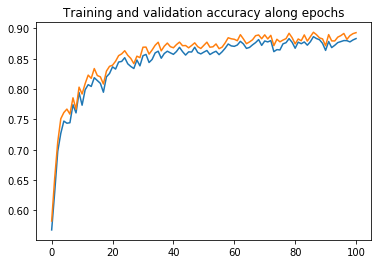

In [26]:
import matplotlib.pyplot as plt

# PLOT ACCURACY

plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title("Training and validation accuracy along epochs")

plt.show()

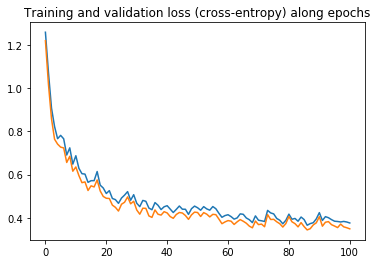

In [27]:
import matplotlib.pyplot as plt

# PLOT LOSS

plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title("Training and validation loss (cross-entropy) along epochs")

plt.show()

If we still do not believe in what is happening, recall that we did a final evaluation using test set, and retrieved final predictions, as well as some output logits. Therefore, we can pick one sample from the test set and check out the actual values that our model predicts.

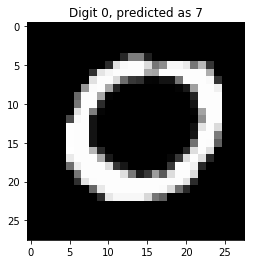

Logits:
 [(0, 5.545579), (1, -6.025017), (2, -2.1205626), (3, -4.7529125), (4, -6.8174977), (5, -0.80819654), (6, 0.20762241), (7, -4.2528877), (8, -3.4302769), (9, -1.9112401)]


In [28]:
import matplotlib.pyplot as plt

random_idx = np.random.randint(0, len(test_images))
random_img = test_images[random_idx].reshape(28, 28)

real_label = test_labels[random_idx]
predicted_label = test_labels[test_predictions[random_idx]]

plt.imshow(random_img, cmap='gray')
plt.title("Digit {}, predicted as {}".format(str(real_label), str(predicted_label)))
plt.show()

print("Logits:\n", list(zip([i for i in range(10)], test_logits[random_idx])))

Okay. By now, we took a lot of effort in understanding all the components we need to build a neural network in TensorFlow. 

We may consider different models for different tasks, but the idea will remain the same. For example, we would minimize different measure for classification task than for regression task. There are also other applications, such as autoencoders, which architecture's shape is even different. And there are other networks apart from fully-connected ones, that would need slightly different handling.

We built our networks with tensors, nodes, creating some quite complicated graphs. Some functions, such as `layer`, were introduced to simplify the implementation and reduce length of a code. But we can build models with more abstract *building blocks* with a support of a wide-known library that has to be mentioned here:

### Keras

Keras is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow, as well as other deep learning frameworks. 

It is famous for enabling fast experimentation with deep neural networks, it focuses on being user-friendly, modular, and extensible. Therefore, we can proceed to more relaxing :) part of describing briefly what such library could do. We will observe that Keras is more high-level in TensorFlow and we won't have to dig that deep into the details. Instead, we can basically start designing a neural network almost straightaway.

In [29]:
print("Keras", tf.keras.__version__)

Keras 2.2.4-tf


### Sequential API

In Keras, there is so-called Sequential API, based on which we can create a neural network **sequentially**. This means, adding more layers and components like building blocks, or, as the documentation says: 
> Sequential model is a linear stack of layers

Instead of making the network more and more complex, and making the problem to solve more difficult, we will stay for now with the simple MNIST digits dataset, so we can see how much effort we can save with the help of Keras. And let's make use of what we already loaded, we have MNIST dataset stored in cache.

Start with verifying whether importing some Keras utilities succeed.

In [87]:
from tensorflow import keras

from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense, Input, LeakyReLU

We do the same loading of data again, with different variables' names, in case the order of cells would mess up too much. We can observe some differences from the very beginning:
 - we do not have to do manual splitting of training set into training and valitation
 - converting different labels into one-hot-encoded vector is simple with the help of `keras.utils.to_categorical` function
 
We will begin with flattening our images, into vectors with 784 elements, but do not worry, we will further proceed possible to more effective architectures when dealing with 2D image data. For the first example to be simple, we will reproduce the neural network from above, which we created in pure TensorFlow.
> There is even `train_test_split` function for splitting all the data we have into train and test. You can provide percentage of entire dataset you would like to save for testing.

In [32]:
((trainX, trainY), (testX, testY)) = keras.datasets.mnist.load_data()

trainX = trainX.reshape((-1, 28*28)).astype("float32")
testX = testX.reshape((-1, 28*28)).astype("float32")

trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

We need to define some hyper parameters, just as in the previous case:

In [33]:
batch_size = 100
num_epochs = 20
learning_rate = 0.25

And proceed to discovering magic of Sequential API. Adding following layers is as simple as calling `.add` function on the object that represents `Sequential()` instance. 

It is on us to specify what the input shape will look like. But only the input shape! The next layers we are going to add will infer suitable shapes automatically. We can read in __[documentation](https://keras.io/getting-started/sequential-model-guide/)__ that there are several ways of specifying input shape, depending on the type of the first layer. In the example below, we use `input_shape=(num_features,)`, so we use one-element tuple for that. But we could have also used `input_dim=num_features`, because our network is fully-connected. You will soon realize that there are many convenient 'tricks' in Keras that are just described in its documentation.

To recreate the network, we only need a few lines below, instantiating an object of type Sequential, and then adding `Dense` layers, which stands for fully-connected layer. We simply pass a number of neurons as a parameter, or a string to specify activation function. Similarily to what we tried to implement on our own with `layer()` function.

The number of possibilities grow, as we can either specify activation function beside the actual layer, or we could add it calling another `.add` method. Only the sequential orders of 'layers' we add matters and determines our model. 

You can see how easy it is to define the last, output layer, we simply put `softmax` activation instead of `sigmoid`, that will do for classifying images. 

Next, we create an instance of `SGD` object, that stands for **Stochastic Gradient Descent**. It is one of many *optimizers* offered by Keras. Some parameters that all of them share include learning rate.

Before training a model, we have to call `.compile` method of our `model` that instantiates object of class Sequential. This configures the learning process. What we have to specify on this step are:
 - what optimizer we want to use - we can identify it with a string or pass an instance of the `Optimizer` class for more flexibility
 - what is the loss function; specifying it can be done in two ways just like the optimizer above,
 - a list of metrics, which is `accuracy` in this case, for our problem we are solving is classification
 
After we have compiled the model, we can begin its training. There is a specific way to do this, offered by `.fit` method of our model. You can probably observe that it is almost readable and requires no further explanation. We pass training examples with their labels as `trainX` and `trainY` parameters and define batch size and number of epochs. Instead of dealing with manual train/validation split, we provide a number, 0.15 that gives the ratio of these two datasets. All of these within one method. Some interesting parameters here include:
- level of verbosity, `verbose`, lets you customize what is output during the training
- `callbacks` parameter, that enables to apply different sets of functions at given stages of the training procedure - this can get even more insights into training progress and statistics.
> My favorite one here is `ModelCheckpoint` callback, that is able to monitor specified quantity, and, for example, save current model if it improved, comparing this quantity. Saving here means literal writing current weights into specified file. I didn't really wonder whether such option existed, until I lost many (many) hours of training on my parents' laptop, because the computer *seemed very loud*. :) See __[here](https://keras.io/callbacks/)__



### Creating model in Keras

In [35]:
model = Sequential()

model.add(Dense(50, input_shape=(num_features,), activation='sigmoid', name='input_layer'))
model.add(Dense(25, activation='sigmoid', name='hidden_layer'))
model.add(Dense(num_labels, activation='softmax', name='output_layer'))

opt = SGD(lr=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainX, trainY, 
                   validation_split=0.2,
                   batch_size=batch_size, epochs=num_epochs,
                   verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 45us/step - loss: 1.1712 - acc: 0.6880 - val_loss: 0.9075 - val_acc: 0.7345
Epoch 2/20
48000/48000 [==============================] - 2s 37us/step - loss: 0.8221 - acc: 0.7394 - val_loss: 0.6748 - val_acc: 0.7929
Epoch 3/20
48000/48000 [==============================] - 1s 29us/step - loss: 0.7938 - acc: 0.7440 - val_loss: 0.7252 - val_acc: 0.7742
Epoch 4/20
48000/48000 [==============================] - 1s 28us/step - loss: 0.7500 - acc: 0.7584 - val_loss: 0.6755 - val_acc: 0.7875
Epoch 5/20
48000/48000 [==============================] - 1s 29us/step - loss: 0.7336 - acc: 0.7608 - val_loss: 0.7631 - val_acc: 0.7422
Epoch 6/20
48000/48000 [==============================] - 1s 28us/step - loss: 0.7218 - acc: 0.7561 - val_loss: 0.6896 - val_acc: 0.7730
Epoch 7/20
48000/48000 [==============================] - 1s 28us/step - loss: 0.6772 - acc: 0.7780 - val_loss: 0.6972 - val_acc

If you want, or don't believe in what you see, you can fall the `.summary` method of the model, that will show all its component, with total numbers of parameters that can be trained.

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 50)                39250     
_________________________________________________________________
hidden_layer (Dense)         (None, 25)                1275      
_________________________________________________________________
output_layer (Dense)         (None, 10)                260       
Total params: 40,785
Trainable params: 40,785
Non-trainable params: 0
_________________________________________________________________


As we can see, training of model in Keras is very fancy. Now let's perform final prediction, exactly as we did in case of TensorFlow.

In [37]:
predictions = model.predict(testX)
print(predictions[0])

[5.9709773e-06 2.3106651e-08 6.8838388e-05 8.0510892e-04 8.8289098e-06
 6.7293299e-06 6.5905931e-10 9.9390537e-01 4.2846655e-06 5.1948912e-03]


Reading from `predictions`, that was returned by `.predict` method, is same as reading last layer's output. We can retrieve all possible class probabilities for particular test set example. 

How about training progress, that we manually collected with pure TensorFlow? We didn't describe yet what `model.fit` returned. We stored it in variable called `H`, that is a `History` object. Using it, we can easily access different measures. Thanks to that, visualizing training progress is as simple as the cell below (source: __[here](https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/)__, like a pro!):

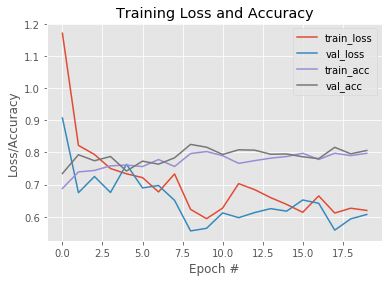

In [38]:
N = np.arange(0, num_epochs)
plt.style.use("ggplot")

plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend()
plt.show()

Great news are, that beside `Dense` layer which set up many things in one line, there are many other possibilities in building our model that are listed in keras documentation under __[core layers](https://keras.io/layers/core/)__. 

Check out the example below, that creates a more complex convolutional neural network. In this case, we will use Fashion MNIST, to try a bit more challenging dataset. It also contains tiny images in grayscale, but this time they depict different clothes, so the task is more difficult.

We finally won't flatten our images into 1D vector, but we can keep it represented in 2D. Therefore we will reload the data and perform different reshaping, followed by normalization by maximum value, which is 255.0 for grayscale pixels representation.

You may note that shape of each image is not described as `(28, 28)`, but rather as `(28, 28, 1)`. Since we have grayscale images, we keep the last number equal to 1, but if it was for color images, we would replace it to number 3, for Red, Green and Blue channel. We also have to make sure that along first dimension (first axis in other words) we have following data samples, and the next ones are their features.

### Fashion MNIST + Convolutional Network in Keras

In [79]:
((trainX, trainY), (testX, testY)) = keras.datasets.fashion_mnist.load_data()
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

print(trainX.shape, testX.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In the cell below, there is an implementation of `create_model` function that will build convolutional network based on Sequential API. You can see that we can easily add such 'improvements' to the network as Dropout regularization, or Batch Normalization. 

Also, notice the `Flatten` layer that is mandatory in order to flatten input coming out from previous convolutional layers. 

The `Conv2D` function defines a 2D convolution layer, which we define by number of filters we want to obtain, followed by filter size. Note that we have `2D` in the function's name and we should therefore specify two-dimensional shape of the filter. It may look like a black-box, as it is supported also with `padding` parameter, and many others.

In [41]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(28,28,1)))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation("softmax"))
    
    return model

We will not do the training again, for the major difference would be more time needed to learn more complex task, and instead of that we will explain another way of building models in Keras: a **functional** way.

### Functional API

Functional API in Keras allows to create more flexible models that Sequential API. What we wouldn't be able to do in the Sequential, and what Functional offers, is defining layers that connect to more than just one previous and one next layer. In fact, layers can connect to any other in this API. And this is real in more complex architectures of neural networks currently known.

In Functional API:
 - you can have multiple input,
 - you can have multiple output,
 - you can share layers along models,
 - you can define directed acyclic graphs,
 - ... and more
 
 To begin with, we need some input and output tensors that will define a `Model`. This is why first object we create instantiates `Input` class. 

In [80]:
# Model input

inputs = Input(shape=(28,28,1), name='inputs')

Next, we define layer instances that are callable on a tensor, and also return a tensor. Notice the syntax used that involves `(inputs)` tensor first, followed by `(layer)`. 

In [81]:
# Convolutional part of our model

layer = Conv2D(32, (3, 3), padding="same", input_shape=(28,28,1))(inputs)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)

layer = Conv2D(32, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)

layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.25)(layer)

layer = Conv2D(64, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)

layer = Conv2D(64, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)

layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.25)(layer)

We defined some first convolutional layers for the model. We continue with the cell below, but we want to store tensor corresponding to `Flatten` layer in a different variable for example (and we will also use it later). 

In [82]:
features = Flatten(name='features')(layer)

layer = Dense(512)(features)
layer = Activation("relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)

layer = Dense(10)(layer)
layer = Activation("softmax")(layer)

Next, we define the model itself instantiating `Model` class. 

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_23 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_24 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 32)        128       
__________

You can train the model below if you want to, with a sufficient number of epochs (preferably more than 10), or just proceed.

In [84]:
model = Model(inputs = inputs, outputs = layer)
model.compile(optimizer=SGD(), loss='categorical_crossentropy',
             metrics=['accuracy'])

H = model.fit(trainX, trainY, validation_data=(testX, testY),
              batch_size=512, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10


KeyboardInterrupt: 

### Functional API for Transfer Learning

We can show the advantage of Functional API by applying so called transfer learning. In this tutorial's directory, you will find `fashion_model.h5` file that contains parameters of a model that was already trained using Fashion MNIST data. We could take same features learned in the convolutional part of the model, and re-train the following dense layers on a specific problem that we have. 

In order to do so, we have to recreate the model first , so that it is the same as the one that was trained. Given that, it is clear how to read the `.h5` file. It is a common file extension for storing models weights. 

In the below example, we load MNIST digits dataset again, because we want to take Fashion MNIST's filters discovered and apply it to some new problem. Not very fortunately, in this case the problem is very simple. We reproduce the model and store it in `old_model` variable. 

Notice how it is easy to load weights with a `.load_weights` method, unless the models actually match. Accessing its layers is as simple as using `.layers` attribute, and we can further freeze each of them by setting single layer's flag `.trainable` to **False**. We can also access particular layer by name, as we can see in:
> `old_model.get_layer('inputs').output`

and take its output at our wish. 

In [85]:
# Load MNIST digits again
((trainX, trainY), (testX, testY)) = keras.datasets.mnist.load_data()
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

# Reproduce the model sufficient fashion_model.h5
old_model = Model(inputs = inputs, outputs = layer)

old_model.compile(optimizer=SGD(), loss='mse')
old_model.load_weights('fashion_model.h5')
for layer in old_model.layers:
    layer.trainable = False # freezes layer's parameters that were loaded

# Start with previously defined FEATURES layer and continue with next layers
layer = Dense(512)(old_model.get_layer('features').output)
layer = Activation("relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)

layer = Dense(10)(layer)
layer = Activation("softmax")(layer)

model = Model(inputs = old_model.get_layer('inputs').output, outputs = layer)

In the cell above, we used `features` layer that was previously highlighted when building an original model, and continued with it to define another network. Starting at the input, and only until that `features` layer, we loaded already trained weights and froze them. 

Summing up, the only thing that the network has to learn now, is to look at the filters we give to it, and find connections between them so that it classifies digits as well as possible. With only slight alterations, we did some transfer learning and we can run the model just like we already did a few times.

Feel free to check how it works in the cell below.

In [86]:
model.compile(loss="categorical_crossentropy", optimizer=SGD(), 
              metrics=["accuracy"])

NUM_EPOCHS = 5
BS = 512
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              batch_size=BS, epochs=NUM_EPOCHS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_29 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_30 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 32)        128       
__________

KeyboardInterrupt: 

We will finish the tutorial for now, providing a brief example what else a Functional API could do. However, the possibilities are endless and you can drown in keras documentation very easily. 

We can create an autoencoder and access its middle part, where the code is stored. In order to do so, we need to use the same logic as we did in the previous example, making use of storing different tensors at our interest in different variables, as well as proper naming the layers.

### Functional API for Autoencoders ...

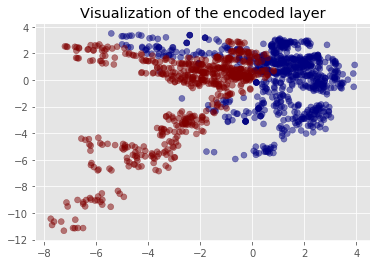

In [98]:
from keras.optimizers import adam

# Load data
csv = np.genfromtxt('data/banknotes.csv', dtype=np.float32, delimiter=",")

Ys = csv[:,[-1]]
Xs = csv[:,:-1]
means = np.mean(Xs, 0)
stdevs = np.std(Xs, 0)
Xs = (Xs-means)/stdevs

# Build model
inputs = Input(shape=(4,),name='inputs')

layer = Dense(16)(inputs)
layer = Activation(LeakyReLU())(layer)

layer = Dense(8)(layer)
layer = Activation(LeakyReLU())(layer)

layer = Dense(2, name='encoded')(layer)
layer = Activation(LeakyReLU())(layer)

layer = Dense(8)(layer)
layer = Activation(LeakyReLU())(layer)

layer = Dense(16)(layer)
layer = Activation(LeakyReLU())(layer)

layer = Dense(4)(layer)

auto_encoder = Model(inputs = inputs, outputs = layer)

# Compile and Train Model
opt = adam(lr=5e-4)
auto_encoder.compile(loss="mse", optimizer=opt)
H = auto_encoder.fit(Xs, Xs, batch_size=30, epochs=300, verbose=0)

# Build encoder that will output the Code
encoder = Model(inputs = inputs, outputs = auto_encoder.get_layer('encoded').output)
encoded = encoder.predict(Xs)
colors = Ys.flatten()

# Visualize the code that the autoencoder determinedb
plt.scatter(encoded[:, 0], encoded[:, 1], c=colors, cmap='jet', alpha=0.5)
plt.title('Visualization of the encoded layer')
plt.show()

# Summary

In this tutorial, I shared my knowledle and understanding on both TensorFlow and Keras, in few different applications of problems. A great advantage over using Python along those two libraries is accesibility of the documentation. The community is also big and finds answers to many questions that beginners may have. 

The first framework described, TensorFlow, allows much low-level access to creating graphs. On the other hand, Keras is high-level framework and sometimes seems as not requiring much knowledge from its user. Therefore, it is very important for the devleloper to understand how things work and not only to use them.

I really hope to continue with such tutorials in the future. :)

Thank you!

REFERENCES:
- this tutorial was strongly based on TensorFlow and Keras documentations   
- https://medium.com/@ouwenhuang/tensorflow-graphs-are-just-protobufs-9df51fc7d08d
- https://medium.com/themlblog/getting-started-with-tensorflow-constants-variables-placeholders-and-sessions-80900727b489 
- https://developers.google.com/protocol-buffers/
- http://yann.lecun.com/exdb/mnist/
- https://jovianlin.io/keras-models-sequential-vs-functional/
- https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5